# 필요모듈 설치


In [ ]:
!pip3 install torch
!pip3 install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 980.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followin

# 필요 모듈 임포트

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from torch.optim.lr_scheduler import StepLR

# 구글 드라이브 연결

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/preprocesse_real_final.csv'

# 데이터 불러와서 Split하기

In [ ]:
seed = 5764

df = pd.read_csv(path, encoding =  'cp949')

df = df.dropna()
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.reset_index()
df = df.drop(['index'], axis = 1)

X = df.iloc[:,(df.columns != 'price')]
y = df.price

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train = train_x.values
y_train = train_y.values.reshape(-1,1)

X_val = train_x.values
y_val = train_y.values.reshape(-1,1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(35708, 40) (15304, 40) (35708,) (15304,)


# TabNet 모델 학습

In [ ]:
clf = TabNetRegressor(optimizer_fn=optim.Adam,
                      optimizer_params=dict(lr=1e-2),
                      scheduler_params={"step_size": 50, "gamma": 0.9},
                      scheduler_fn=StepLR,
                      mask_type='sparsemax'
                      )
max_epochs = 1000

clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    max_epochs=max_epochs,
    patience=20,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.21753 | val_0_mse: 0.0434  |  0:00:05s
epoch 1  | loss: 0.03634 | val_0_mse: 0.03471 |  0:00:07s
epoch 2  | loss: 0.02389 | val_0_mse: 0.02872 |  0:00:10s
epoch 3  | loss: 0.01973 | val_0_mse: 0.02419 |  0:00:11s
epoch 4  | loss: 0.01713 | val_0_mse: 0.02233 |  0:00:13s
epoch 5  | loss: 0.01512 | val_0_mse: 0.0206  |  0:00:16s
epoch 6  | loss: 0.01341 | val_0_mse: 0.01881 |  0:00:18s
epoch 7  | loss: 0.01206 | val_0_mse: 0.01778 |  0:00:20s
epoch 8  | loss: 0.01103 | val_0_mse: 0.01607 |  0:00:22s
epoch 9  | loss: 0.01029 | val_0_mse: 0.01456 |  0:00:24s
epoch 10 | loss: 0.00993 | val_0_mse: 0.01347 |  0:00:26s
epoch 11 | loss: 0.00976 | val_0_mse: 0.01271 |  0:00:28s
epoch 12 | loss: 0.00932 | val_0_mse: 0.01116 |  0:00:30s
epoch 13 | loss: 0.00908 | val_0_mse: 0.0108  |  0:00:33s
epoch 14 | loss: 0.00892 | val_0_mse: 0.0098  |  0:00:35s
epoch 15 | loss: 0.00879 | val_0_mse: 0.0092  |  0:00:36s
epoch 16 | loss: 0.0085  | val_0_mse: 0.0087  |  0:00:38s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 테스트

In [ ]:
preds_te = clf.predict(test_x.values)
preds_tr = clf.predict(X_train)
#test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
r2 = r2_score(train_y, preds_tr)
print("r2 : {:.5f}".format(r2))

0.8597475224339038
r2 : 0.85975


# 시각화

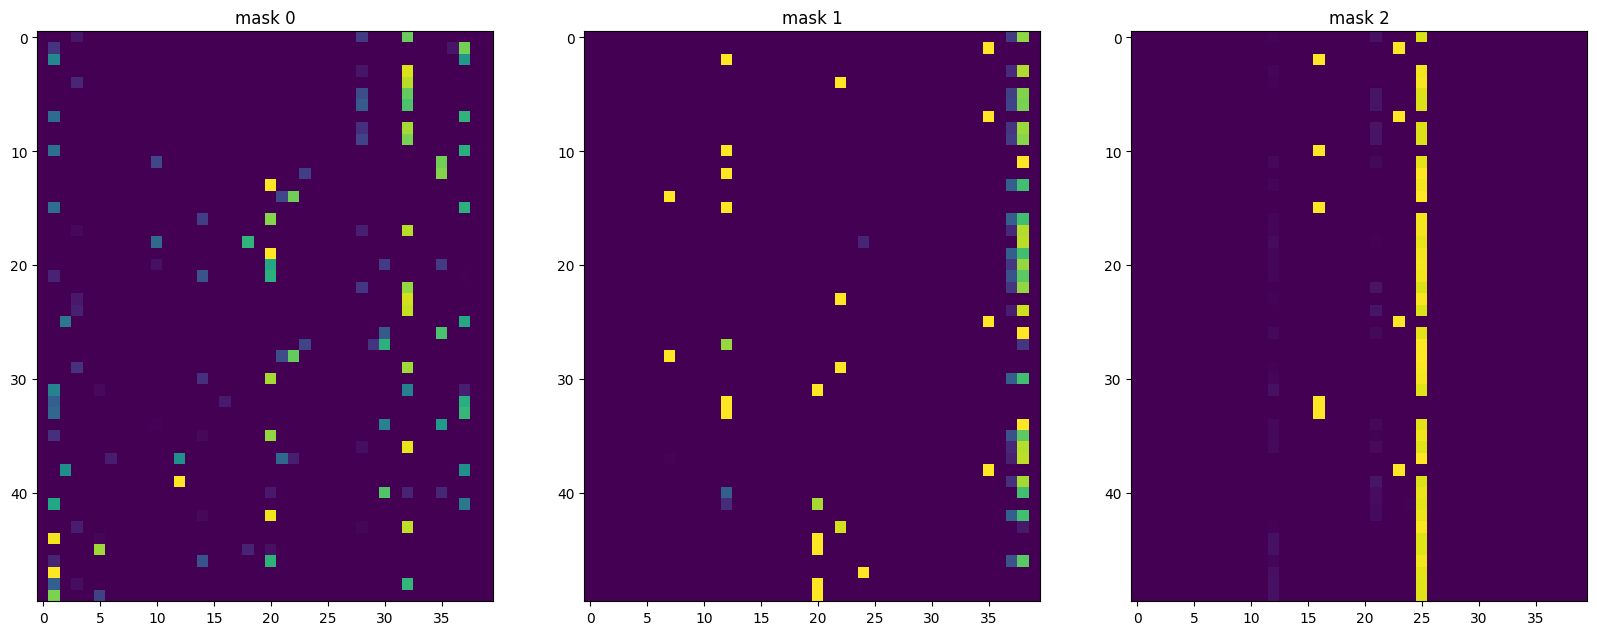

In [ ]:
explain_matrix, masks = clf.explain(test_x.values)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [ ]:
import matplotlib.pyplot as plt

pre = pd.DataFrame(pred)
test_y = test_y.reset_index()
result = pd.concat([test_y, pre], axis = 1)
result.columns = ['a', 'real', 'predict']

fig = plt.figure(figsize = (12,4))
chart = fig.add_subplot(1,1,1)
chart.plot(result.real[:800],  color = 'blue', label = 'y')
chart.plot(result.predict[:800],  color = 'red', label = 'predict_y')
chart.set_title('CatBoost Result', size=30)
plt.xlabel('num', size = 20)
plt.ylabel('price', size = 20)
plt.legend(loc = 'best')